In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

In [2]:
import sys
sys.path.append("./../")

from modules.dvae.model import DVAE
from modules.dvae.funcs import ng_quantize

from modules.common_blocks import ResidualStack
from modules.dtr_gan.blocks import PositionalEmbedding, MLP
from train_utils.dvae_utils import TemperatureAnnealer

In [3]:
def show(img, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [4]:
class Config:
    DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_channels                = 1
    vocab_size                  = 32

    noise_dim                   = 16
    hidden_height               = 7
    hidden_width                = 7

    num_blocks                  = 10
    n_attn_heads                = 8
    hidden_dim                  = 256
    dropout_prob                = 0.1

    dvae_num_x2upsamples        = 2
    dvae_num_resids_downsample  = 3
    dvae_num_resids_bottleneck  = 4
    dvae_hidden_dim             = 256

    load_dvae_path              = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/dvae_S_mnist/"
    dvae_model_name             = "dvae_S_mnist"
    data_path                   = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"

    temp_start                  = 10
    temp_end                    = 0.01
    temp_steps                  = 100 * 50
    
    NUM_EPOCHS                  = 100
    BATCH_SIZE                  = 512
    LR                          = 0.0001
    LR_gamma                    = 0.1
    step_LR_milestones          = [90]


CONFIG = Config()

In [5]:
data_transforms = torch_transforms.Compose([
    torch_transforms.RandomRotation(10),
    torch_transforms.ToTensor()
])

trainset = datasets.MNIST(
    CONFIG.data_path,
    train=True,
    download=False,
    transform=data_transforms)

train_loader = DataLoader(
    trainset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True)


In [6]:
len(trainset) / CONFIG.BATCH_SIZE

117.1875

In [7]:
class Generator(nn.Module):
    def __init__(self,
                 noise_dim,
                 hidden_width,
                 hidden_height,
                 embedding_dim,
                 num_blocks,
                 dropout_prob):
        super(Generator, self).__init__()

        self.hidden_width = hidden_width
        self.hidden_height = hidden_height
        self.embedding_dim = embedding_dim
        bias = True

        self.noise_converter = nn.Sequential(
            nn.ConvTranspose2d(in_channels=noise_dim, out_channels=embedding_dim, 
                               kernel_size=3, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=embedding_dim, out_channels=embedding_dim, 
                               kernel_size=3, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=embedding_dim, out_channels=embedding_dim, 
                               kernel_size=3, stride=1, padding=0, bias=bias)
        )

        self.residual = ResidualStack(
            in_channels=embedding_dim,
            out_channels=embedding_dim,
            num_residual_layers=num_blocks,
            bias=bias,
            use_bn=True,
            final_relu=False)

    def forward(self, noise):
        x = self.noise_converter(noise)
        z_logits = self.residual(x)
        z = F.softmax(z_logits, dim=1)
        return z


In [8]:
class Discriminator(nn.Module):
    def __init__(self,
                 embedding_dim,
                 num_blocks):
        super(Discriminator, self).__init__()
        
        self.resid = ResidualStack(
            in_channels=embedding_dim, 
            out_channels=embedding_dim, 
            num_residual_layers=num_blocks, 
            bias=True, 
            use_bn=True, 
            final_relu=False)
        
        channels_dims = [
            embedding_dim // 2,
            embedding_dim // 4,
        ]
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=embedding_dim,
                      out_channels=channels_dims[0],
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=channels_dims[0]),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels_dims[0], 
                      out_channels=channels_dims[1], 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=channels_dims[1]),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels_dims[1], 
                      out_channels=channels_dims[1], 
                      kernel_size=3, padding=0),
            nn.ReLU(),
        )
        
        self.fc = nn.Linear(in_features=channels_dims[1], out_features=1)

    def forward(self, x):
        x = self.resid(x)
        x = self.conv(x)
        x = self.fc(x.squeeze())
        return torch.sigmoid(x.squeeze())

In [9]:
dvae = DVAE(
    in_channels=CONFIG.img_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.dvae_num_x2upsamples,
    num_resids_downsample=CONFIG.dvae_num_resids_downsample,
    num_resids_bottleneck=CONFIG.dvae_num_resids_bottleneck,
    hidden_dim=CONFIG.dvae_hidden_dim)

G = Generator(
    noise_dim=CONFIG.noise_dim,
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    dropout_prob=CONFIG.dropout_prob)

D = Discriminator(
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks)

optimizer_G = optim.Adam(G.parameters(), lr=CONFIG.LR)
optimizer_D = optim.Adam(D.parameters(), lr=CONFIG.LR)

lr_scheduler_G = MultiStepLR(optimizer_G, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)
lr_scheduler_D = MultiStepLR(optimizer_D, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)


In [10]:
dvae.eval()
G.train()
D.train()

dvae.load_model(
    root_path=CONFIG.load_dvae_path,
    model_name=CONFIG.dvae_model_name)

dvae.to(CONFIG.DEVICE)
G.to(CONFIG.DEVICE)
D.to(CONFIG.DEVICE)

pass

Device in use: cuda
Epoch: 0 Iter: 55 GLoss: 0.90877 DLoss: 0.78597 Avg_D_real 0.77546 Avg_D_fake 0.41104
Epoch: 0 Iter: 110 GLoss: 1.283 DLoss: 0.50297 Avg_D_real 0.84313 Avg_D_fake 0.28229
Epoch: 1 Iter: 165 GLoss: 1.5425 DLoss: 0.37511 Avg_D_real 0.87814 Avg_D_fake 0.21708
Epoch: 1 Iter: 220 GLoss: 1.82652 DLoss: 0.28234 Avg_D_real 0.90059 Avg_D_fake 0.16261
Epoch: 2 Iter: 275 GLoss: 2.03231 DLoss: 0.22826 Avg_D_real 0.91746 Avg_D_fake 0.13239
Epoch: 2 Iter: 330 GLoss: 2.2259 DLoss: 0.18821 Avg_D_real 0.93047 Avg_D_fake 0.10953
Epoch: 3 Iter: 385 GLoss: 2.4166 DLoss: 0.15385 Avg_D_real 0.94226 Avg_D_fake 0.09002
Epoch: 3 Iter: 440 GLoss: 2.59489 DLoss: 0.12851 Avg_D_real 0.95116 Avg_D_fake 0.07541
Epoch: 4 Iter: 495 GLoss: 2.76953 DLoss: 0.10772 Avg_D_real 0.9584 Avg_D_fake 0.06313
Epoch: 4 Iter: 550 GLoss: 2.90725 DLoss: 0.09386 Avg_D_real 0.96419 Avg_D_fake 0.05571
====== Epoch 4 ======


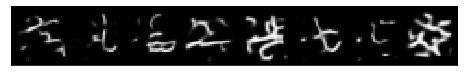

Epoch: 5 Iter: 605 GLoss: 3.06092 DLoss: 0.08054 Avg_D_real 0.96885 Avg_D_fake 0.04769


KeyboardInterrupt: 

In [11]:
print("Device in use: {}".format(CONFIG.DEVICE))

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for x, label in train_loader:
        x = x.to(CONFIG.DEVICE)
        
        with torch.no_grad():
            real = dvae.ng_q_encode(x)
            real = F.softmax(real + torch.rand(real.size(), device=real.device), dim=1)

        current_batch_dim = real.size(0)
        labels_real = torch.full((current_batch_dim,), 1.0, device=CONFIG.DEVICE)
        labels_fake = torch.full((current_batch_dim,), 0.0, device=CONFIG.DEVICE)

        D.zero_grad()
        G.zero_grad()
        
        ############################
        ### Update Discriminator ###
        ############################
        
        noise = torch.randn(current_batch_dim, CONFIG.noise_dim, 1, 1, device=CONFIG.DEVICE)
        fake = G(noise=noise)

        labels_D_real = D(real)
        d_loss_real = F.binary_cross_entropy(labels_D_real, labels_real)

        labels_D_fake = D(fake.detach())
        d_loss_fake = F.binary_cross_entropy(labels_D_fake, labels_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        avg_label_D_real = labels_D_real.mean().item()
        avg_label_D_fake = labels_D_fake.mean().item()

        ############################
        ##### Update Generator #####
        ############################

        labels_D_fake = D(fake)

        g_loss = F.binary_cross_entropy(labels_D_fake, labels_real)
        g_loss.backward()
        optimizer_G.step()

        iteration += 1

        if iteration % 55 == 0:
            print("Epoch: {} Iter: {} GLoss: {} DLoss: {} Avg_D_real {} Avg_D_fake {}".format(
                epoch, 
                iteration, 
                round(g_loss.item(), 5), 
                round(d_loss.item(), 5), 
                round(avg_label_D_real, 5), 
                round(avg_label_D_fake, 5),
                #round(temp, 5)
            ))
    
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_img = dvae.ng_q_decode(fake[:8, :, :, :])
        img_grid = make_grid(fake_img.detach().cpu())
        print("====== Epoch {} ======".format(epoch))
        show(img_grid)
        print("======================")

In [ ]:
# x, label = next(iter(train_loader))
# x = x.to(CONFIG.DEVICE)

# with torch.no_grad():
#     real = dvae.ng_q_encode(x)

In [ ]:
# def compute_norm_weights(log_w):
#     log_n = torch.log(torch.tensor(float(log_w.shape[0])))
#     log_z_est = torch.logsumexp(log_w - log_n, dim=0)
#     log_w_tilde = log_w - log_z_est - log_n

#     w_tilde = torch.exp(log_w_tilde)

#     return w_tilde

# def multinomial_bgan_loss(D, fake_logits, reals, n_samples=8):
#     batch_size = reals.size(0)
#     n_channels = fake_logits.size(1)
#     spatial_dims = fake_logits.shape[2:]

#     fake_p = torch.softmax(fake_logits, dim=1).view(batch_size, n_channels, -1).transpose(1, 2)
#     fake_p = fake_p.repeat(n_samples, 1, 1).view(-1, n_channels)

#     samples = torch.multinomial(fake_p, num_samples=1)
#     samples = samples.view(n_samples, batch_size, *spatial_dims)

#     samples_one_hot = F.one_hot(samples, num_classes=n_channels).type(torch.float)
#     samples_one_hot = samples_one_hot.permute(0, 1, 4, 2, 3)

#     real_out = D(reals)
#     fake_out = D(samples_one_hot.view(-1, *samples_one_hot.shape[2:]))

#     log_w = fake_out.view(n_samples, batch_size)
#     log_g = -(samples_one_hot * (
#         fake_logits - torch.logsumexp(fake_logits, dim=1, keepdim=True)
#     ).unsqueeze(0)).mean(dim=(2, 3, 4))

#     w_tilde = compute_norm_weights(log_w).detach()

#     d_loss = F.binary_cross_entropy_with_logits(real_out, torch.ones_like(real_out)) + \
#              F.binary_cross_entropy_with_logits(fake_out, torch.zeros_like(fake_out))
#     g_loss = (w_tilde * log_g).sum(0).mean()

#     p_fake = (fake_out < 0).type(torch.float).mean().detach()
#     p_real = (real_out > 0).type(torch.float).mean().detach()

#     return d_loss, g_loss, p_fake, p_real

In [ ]:
# print("Device in use: {}".format(CONFIG.DEVICE))

# iteration = 0
# for epoch in range(CONFIG.NUM_EPOCHS):
#     for x, label in train_loader:
#         x = x.to(CONFIG.DEVICE)
        
#         with torch.no_grad():
#             real = dvae.q_encode(x, hard=True)

#         current_batch_dim = real.size(0)
        
#         #D.zero_grad()
#         #G.zero_grad()
        
#         noise = torch.randn(current_batch_dim, CONFIG.noise_dim, 1, 1, device=CONFIG.DEVICE)
#         fake = G(noise=noise)
        
#         d_loss, g_loss, p_fake, p_real = multinomial_bgan_loss(
#             D=D,
#             fake_logits=fake,
#             reals=real,
#             n_samples=20)
        
#         optimizer_D.zero_grad()
#         optimizer_G.zero_grad()

#         torch.autograd.backward([d_loss, g_loss])

#         optimizer_D.step()
#         optimizer_G.step()
        
#         iteration += 1

#         if iteration % 25 == 0:
#             print("Epoch: {} Iter: {} GLoss: {} DLoss: {}".format(
#                 epoch, 
#                 iteration, 
#                 round(g_loss.item(), 5), 
#                 round(d_loss.item(), 5)
#             ))
    
#     if (epoch + 1) % 5 == 0:
#         with torch.no_grad():
#             fake_img = dvae.q_decode(fake[:8, :, :, :], hard=True)
#         img_grid = make_grid(fake_img.detach().cpu())
#         print("====== Epoch {} ======".format(epoch))
#         show(img_grid)
#         print("======================")